In [1]:
# https://www.kaggle.com/moeinshariatnia/indonesian-distilbert-finetuning-with-arcmargin
import os
import copy
import math
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import transformers
from transformers import (BertTokenizer, BertModel,
                          DistilBertTokenizer, DistilBertModel)
from transformers import (AutoTokenizer, AutoModel, AutoModelForMaskedLM, 
                          AutoModelForSequenceClassification, AutoModelForQuestionAnswering,
                         AutoModelForTokenClassification, AutoModelForSeq2SeqLM)

import torch

import warnings
warnings.filterwarnings('ignore')

# Day 2- 
# paraphrase-xlm-r-multilingual-v1 (0.590)
# roberta-base-nli-stsb-mean-token_25_epochs.pt (jupyter showed to 12 epochs only) (0.558)
# bert-base-nli-cls-token_25_epochs.pt
# quora-distilbert-multilingual (0.557)
# ce-distilroberta-base-stsb
# stsb-xlm-r-multilingual (0.581)

# Day 3 -
# msmarco-distilbert-base-v2 (done)
# roberta-large-nli-stsb-mean-tokens (NO)
# msmarco-distilbert-base-v3 (done) (0.566)
# distilbert-multilingual-nli-stsb-quora-ranking (done) (0.558)

# Day 4
# distilbert-base-nli-stsb-quora-ranking
# xlm-r-100langs-bert-base-nli-mean-tokens (done) (0.587)
# msmarco-distilroberta-base-v2
# stsb-bert-large
# ce-roberta-large-stsb
# bert-large-nli-mean-tokens
# ce-roberta-base-stsb

# Day 4 multilingual
# **distilbert-base-multilingual-cased (done) (0.526)
# from transformers import AutoTokenizer, AutoModelForMaskedLM
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
# model = AutoModelForMaskedLM.from_pretrained("distilbert-base-multilingual-cased")
# **bert-multilingual-passage-reranking-msmarco (done) (0.552)
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# tokenizer = AutoTokenizer.from_pretrained("amberoad/bert-multilingual-passage-reranking-msmarco")
# model = AutoModelForSequenceClassification.from_pretrained("amberoad/bert-multilingual-passage-reranking-msmarco")
# ** Multilingual-MiniLM-L12-H384 (error)
# ** distilbert-base-multilingual-cased (repeat)
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
# model = AutoModelForMaskedLM.from_pretrained("distilbert-base-multilingual-cased")
# ** bert-base-multilingual-cased-sentence (done) (0.581)
# ** bert-base-multilingual-cased-korquad (done) (0.564)
# tokenizer = AutoTokenizer.from_pretrained("sangrimlee/bert-base-multilingual-cased-korquad")
# model = AutoModelForQuestionAnswering.from_pretrained("sangrimlee/bert-base-multilingual-cased-korquad")

# Day -5 (multilingual)
# ** bert-base-multilingual-cased-finetuned-squad (done) (0.555)
# tokenizer = AutoTokenizer.from_pretrained("salti/bert-base-multilingual-cased-finetuned-squad")
# model = AutoModelForQuestionAnswering.from_pretrained("salti/bert-base-multilingual-cased-finetuned-squad")
# ** bert-base-multilingual-cased-finetuned-conll2002-ner (wont do)
# tokenizer = AutoTokenizer.from_pretrained("wietsedv/bert-base-multilingual-cased-finetuned-conll2002-ner")
# model = AutoModelForTokenClassification.from_pretrained("wietsedv/bert-base-multilingual-cased-finetuned-conll2002-ner")
# ** bert-base-multilingual-codemixed-cased-sentiment (done) (0.552)
# tokenizer = AutoTokenizer.from_pretrained("rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment")
# model = AutoModelForSequenceClassification.from_pretrained("rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment")
# ** multilingual-toxic-xlm-roberta (done) (0.568)
# tokenizer = AutoTokenizer.from_pretrained("unitary/multilingual-toxic-xlm-roberta")
# model = AutoModelForSequenceClassification.from_pretrained("unitary/multilingual-toxic-xlm-roberta")
# ** bert-base-multilingual-cased-finetuned (error)
# tokenizer = AutoTokenizer.from_pretrained("airesearch/bert-base-multilingual-cased-finetuned")
# model = AutoModelForMaskedLM.from_pretrained("airesearch/bert-base-multilingual-cased-finetuned")
# ** bert-base-multilingual-cased-finetuned-sonar-ner (wont do)
# tokenizer = AutoTokenizer.from_pretrained("wietsedv/bert-base-multilingual-cased-finetuned-sonar-ner")
# model = AutoModelForTokenClassification.from_pretrained("wietsedv/bert-base-multilingual-cased-finetuned-sonar-ner")
# ** bert-base-multilingual-cased-finetuned-udlassy-ner (wont do)
# tokenizer = AutoTokenizer.from_pretrained("wietsedv/bert-base-multilingual-cased-finetuned-udlassy-ner")
# model = AutoModelForTokenClassification.from_pretrained("wietsedv/bert-base-multilingual-cased-finetuned-udlassy-ner")
# ** TRAC2020_ALL_C_bert-base-multilingual-uncased (done) (0.539)
# tokenizer = AutoTokenizer.from_pretrained("socialmediaie/TRAC2020_ALL_C_bert-base-multilingual-uncased")
# model = AutoModelForSequenceClassification.from_pretrained("socialmediaie/TRAC2020_ALL_C_bert-base-multilingual-uncased")
# ** monotransquest-da-multilingual (error)
# tokenizer = AutoTokenizer.from_pretrained("TransQuest/monotransquest-da-multilingual")
# model = AutoModelForSequenceClassification.from_pretrained("TransQuest/monotransquest-da-multilingual")

# Day -6 (multiligual)
# ** bert-base-multilingual-cased-finetune-qa (done) (best f1 at 0.01 - won't do)
# tokenizer = AutoTokenizer.from_pretrained("cstorm125/bert-base-multilingual-cased-finetune-qa")
# model = AutoModelForQuestionAnswering.from_pretrained("cstorm125/bert-base-multilingual-cased-finetune-qa")
# ** distilbert-base-multilingual-cased-finetuned-squad-v2 (done) (0.564)
# tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-base-multilingual-cased-finetuned-squad-v2")
# model = AutoModelForQuestionAnswering.from_pretrained("lvwerra/distilbert-base-multilingual-cased-finetuned-squad-v2")
# ** bert2bert-multilingual_shared-question-generation (error)
# tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert2bert-multilingual_shared-question-generation")
# model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/bert2bert-multilingual_shared-question-generation")
# ** multilingual-codesearch (error)
# ** bert-base-multilingual-cased-nsmc (done) (0.572)
# tokenizer = AutoTokenizer.from_pretrained("sackoh/bert-base-multilingual-cased-nsmc")
# model = AutoModelForSequenceClassification.from_pretrained("sackoh/bert-base-multilingual-cased-nsmc")

# ** Final models
# paraphrase-xlm-r-multilingual-v1 (0.590)
# stsb-xlm-r-multilingual (0.581)
# xlm-r-100langs-bert-base-nli-mean-tokens (done) (0.587)
# bert-base-multilingual-cased-sentence (done) (0.581)
# on training set without training
# msmarco-distilbert-base-v3: Our best score is 0.6210519837177707 and has a threshold 8.8
# msmarco-distilbert-base-dot-prod-v3: Our best score is 0.6261519622106636 and has a threshold 5.9

# Day -7 ( 5 models 15 epochs)
# paraphrase-xlm-r-multilingual-v1 (done) (0.587)
# stsb-xlm-r-multilingual (done) (0.602)
# xlm-r-100langs-bert-base-nli-mean-tokens (done) (0.592)
# bert-base-multilingual-cased-sentence (done)(0.586)
# msmarco-distilbert-base-v3 (done) (0.592)

# Day - 8 (4 models, 10 epochs)
# stsb-xlm-r-multilingual (done) (0.607)
# xlm-r-100langs-bert-base-nli-mean-tokens (done) (0.604)
# bert-base-multilingual-cased-sentence (done) (0.585)
# msmarco-distilbert-base-v3 (done) (0.584)

# paraphrase-xlm-r-multilingual-v1 (35 epochs) (0.572)

# Day 9 (2 models, 5 epochs)
# stsb-xlm-r-multilingual (done) (0.598)
# xlm-r-100langs-bert-base-nli-mean-tokens (done) (0.584)

# final (text)
# paraphrase-xlm-r-multilingual-v1 (25 epochs)
# stsb-xlm-r-multilingual (10 epochs)
# xlm-r-100langs-bert-base-nli-mean-tokens (10 epochs)
# bert-base-multilingual-cased-sentence  (15 epochs)
# msmarco-distilbert-base-v3 (15 epochs)

# org ensemble: KNN, 1.93, 0.622
#                    1.98, 0.615

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
df_train = pd.read_csv("../data/train.csv")
df_train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


MIN words: 1, MAX words: 61


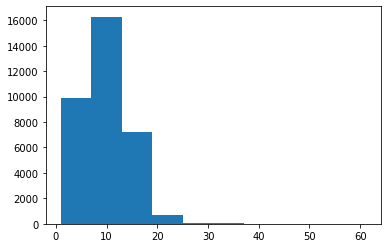

In [3]:
title_lengths = df_train['title'].apply(lambda x: len(x.split(" "))).to_numpy()
print(f"MIN words: {title_lengths.min()}, MAX words: {title_lengths.max()}")
plt.hist(title_lengths);

In [4]:
# titles_1 = df_train.title.values
# titles_1 = [s.lower() for s in titles_1]
# titles_1

In [5]:
class CFG:
    DistilBERT = True # if set to False, BERT model will be used
    bert_hidden_size = 768
    
    batch_size = 64
    epochs = 5
    num_workers = 4
    learning_rate = 3e-5 #3e-5
    scheduler = "ReduceLROnPlateau"
    step = 'epoch'
    patience = 2
    factor = 0.8
    dropout = 0.5
    model_path = "../cache"
    model_name = "/home/watts/lal/Kaggle/kshop/xlm-r-100langs-bert-base-nli-mean-tokens"
    max_length = 70
    model_save_name = "text_model_xlm-r-100langs-bert-base-nli-mean-tokens_5_epochs.pt"
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [6]:
# if CFG.DistilBERT:
#     model_name='cahya/distilbert-base-indonesian'
#     tokenizer = DistilBertTokenizer.from_pretrained(model_name)
#     bert_model = DistilBertModel.from_pretrained(model_name)


In [7]:
# import os
# os.listdir(CFG.model_name)

In [8]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask



# Queries we want embeddings for
queries = ['What is the capital of France?', 'How many people live in New York City?']

# Passages that provide answers
passages = ['Paris is the capital of France', 'New York City is the most populous city in the United States, with an estimated 8,336,817 people living in the city, according to U.S. Census estimates dating July 1, 2019']


#Load AutoModel from huggingface model repository
print(CFG.model_name)
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)
# tokenizer = AutoTokenizer.from_pretrained("microsoft/Multilingual-MiniLM-L12-H384")
distilbert_model = None
try:
    distilbert_model = AutoModel.from_pretrained(CFG.model_name).to('cuda')
except:
    distilbert_model = None

if distilbert_model == None:
    try:
        distilbert_model = AutoModelForMaskedLM.from_pretrained(CFG.model_name).to('cuda')
    except:
        distilbert_model = None


if distilbert_model == None:
    try:
        distilbert_model = AutoModelForSequenceClassification.from_pretrained(CFG.model_name).to('cuda')
    except:
        distilbert_model = None


if distilbert_model == None:
    try:
        distilbert_model = AutoModelForQuestionAnswering.from_pretrained(CFG.model_name).to('cuda')
    except:
        distilbert_model = None

if distilbert_model == None:
    try:
        distilbert_model = AutoModelForTokenClassification.from_pretrained(CFG.model_name).to('cuda')
    except:
        distilbert_model = None
        
if distilbert_model == None:
    try:
        distilbert_model = AutoModelForSeq2SeqLM.from_pretrained(CFG.model_name).to('cuda')
    except:
        distilbert_model = None


def compute_embeddings(sentences):
    #Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt').to('cuda')

    #Compute query embeddings
    with torch.no_grad():
        model_output = distilbert_model(**encoded_input)

    #Perform pooling. In this case, mean pooling
    return mean_pooling(model_output, encoded_input['attention_mask'])

/home/watts/lal/Kaggle/kshop/xlm-r-100langs-bert-base-nli-mean-tokens


In [9]:
encoded_input = tokenizer(queries, padding=True, truncation=True, return_tensors='pt')

In [10]:
encoded_input

{'input_ids': tensor([[    0,  4865,    83,    70, 10323,   111,  9942,    32,     2,     1,
             1],
        [    0, 11249,  5941,  3395,  6867,    23,  2356,  5753,  6406,    32,
             2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [11]:
query_embeddings = compute_embeddings(queries)
passage_embeddings = compute_embeddings(passages)
query_embeddings.shape, passage_embeddings.shape

(torch.Size([2, 768]), torch.Size([2, 768]))

In [12]:
lbl_encoder = LabelEncoder()
df_train['label_code'] = lbl_encoder.fit_transform(df_train['label_group'])
NUM_CLASSES = df_train['label_code'].nunique()

In [13]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, mode="train", max_length=None):
        self.dataframe = dataframe
        if mode != "test":
            self.targets = dataframe['label_code'].values
        titles_1 = dataframe.title.values
        titles_1 = [s.replace('(', '') for s in titles_1]
        titles_1 = [s.replace(')', '') for s in titles_1]
        titles_1 = [s.replace('[', '') for s in titles_1]

        import re
        titles_1 = [s.replace('\\\\', '\\') for s in titles_1]
        titles_1 = [re.sub(r'\\x[0-f]{2}',r'', s) for s in titles_1]
        titles_1 = [s.replace('b"', '') for s in titles_1]
        titles_1 = [s.replace('"', '') for s in titles_1]
        titles_1 = [s.lower() for s in titles_1]
        dataframe['title'] = titles_1
        texts = list(dataframe['title'].apply(lambda o: str(o)).values)
        self.encodings = tokenizer(texts, 
                                   padding=True, 
                                   truncation=True, 
                                   max_length=max_length,
                                   return_tensors='pt')
        self.mode = mode
        
        
    def __getitem__(self, idx):
        # putting each tensor in front of the corresponding key from the tokenizer
        # HuggingFace tokenizers give you whatever you need to feed to the corresponding model
        item = {key: torch.tensor(values[idx]) for key, values in self.encodings.items()}
        # when testing, there are no targets so we won't do the following
        if self.mode != "test":
            item['labels'] = torch.tensor(self.targets[idx]).long()
        return item
    
    def __len__(self):
        return len(self.dataframe)

In [14]:
dataset = TextDataset(df_train, tokenizer, max_length=CFG.max_length)
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=CFG.batch_size, 
                                         num_workers=CFG.num_workers, 
                                         shuffle=True)
batch = next(iter(dataloader))
print(batch['input_ids'].shape, batch['labels'].shape)

torch.Size([64, 70]) torch.Size([64])


In [15]:
batch

{'input_ids': tensor([[    0,   604,  3422,  ...,     1,     1,     1],
         [    0, 34260, 10537,  ...,     1,     1,     1],
         [    0,   604, 93371,  ...,     1,     1,     1],
         ...,
         [    0,  4191, 59760,  ...,     1,     1,     1],
         [    0, 47014,    67,  ...,     1,     1,     1],
         [    0,   104,   238,  ...,     1,     1,     1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([ 2147,  2871,  2416, 10924,   227,  1329,  2827,   560,  4880,  1053,
          9315,  9995,  9874,  5602,  8159,  1025,  7852,   771,   502,  1111,
          2566,  9001,  2613,  5929,  8671,  8352,  3700,  3887,  4650,   871,
          2147,  1936,  2912,  7400,  6391,  8824,  8526,  7014,  9837,  1681,
          1544, 10587,  2880,  7401,  4964,  99

In [16]:
# code from https://github.com/ronghuaiyang/arcface-pytorch/blob/47ace80b128042cd8d2efd408f55c5a3e156b032/models/metrics.py#L10

class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        
    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=CFG.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output


In [17]:
class Model(nn.Module):
    def __init__(self, 
                 bert_model, 
                 num_classes=NUM_CLASSES, 
                 last_hidden_size=CFG.bert_hidden_size):
        
        super().__init__()
        self.bert_model = bert_model
        self.arc_margin = ArcMarginProduct(last_hidden_size, 
                                           num_classes, 
                                           s=30.0, 
                                           m=0.50, 
                                           easy_margin=False)
        self.batch = {}
    
    def my_mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def my_compute_embeddings(self, batch):
        #Tokenize sentences
#         encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

        #Compute query embeddings
        with torch.no_grad():
            model_output = self.bert_model(**batch)

        #Perform pooling. In this case, mean pooling
        return self.my_mean_pooling(model_output, batch['attention_mask'])
    def get_bert_features(self, batch):
        self.batch['input_ids'] = batch['input_ids']
        self.batch['attention_mask'] = batch['attention_mask']
        CLS_token_state  = self.my_compute_embeddings(self.batch)
#         output = self.bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
#         last_hidden_state = output.last_hidden_state # shape: (batch_size, seq_length, bert_hidden_dim)
#         CLS_token_state = last_hidden_state[:, 0, :] # obtaining CLS token state which is the first token.
        return CLS_token_state
    
    def get_bert_features2(self, batch):
        x = self.bert_model(input_ids=batch['input_ids'],attention_mask=batch['attention_mask'])
        
        features = x[0]
        features = features[:,0,:]
        
    def forward(self, batch):
        CLS_hidden_state = self.get_bert_features(batch)
#         print(CLS_hidden_state)
        output = self.arc_margin(CLS_hidden_state, batch['labels'])
#         print(CLS_hidden_state)
        return CLS_hidden_state, output

In [18]:
class Model2(nn.Module):
    def __init__(self, 
                 bert_model, 
                 num_classes=NUM_CLASSES, 
                 last_hidden_size=CFG.bert_hidden_size):
        
        super().__init__()
        self.bert_model = bert_model
        self.arc_margin = ArcMarginProduct(last_hidden_size, 
                                           num_classes, 
                                           s=30.0, 
                                           m=0.50, 
                                           easy_margin=False)
        self.batch = {}
    
    def my_mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def my_compute_embeddings(self, batch):
        #Tokenize sentences
#         encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

        #Compute query embeddings
        with torch.no_grad():
            model_output = self.bert_model(**batch)

        #Perform pooling. In this case, mean pooling
        return self.my_mean_pooling(model_output, batch['attention_mask'])
    def get_bert_features(self, batch):
        self.batch['input_ids'] = batch['input_ids']
        self.batch['attention_mask'] = batch['attention_mask']
        CLS_token_state  = self.my_compute_embeddings(self.batch)
#         output = self.bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
#         last_hidden_state = output.last_hidden_state # shape: (batch_size, seq_length, bert_hidden_dim)
#         CLS_token_state = last_hidden_state[:, 0, :] # obtaining CLS token state which is the first token.
        return CLS_token_state
    
    def get_bert_features2(self, batch):
        x = self.bert_model(input_ids=batch['input_ids'],attention_mask=batch['attention_mask'])
        
        features = x[0]
        features = features[:,0,:]
        return features
    def forward(self, batch):
        CLS_hidden_state = self.get_bert_features2(batch)
#         print(CLS_hidden_state)
        output = self.arc_margin(CLS_hidden_state, batch['labels'])
#         print(CLS_hidden_state)
        return F.normalize(CLS_hidden_state), output

In [19]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()
    
    def reset(self):
        self.avg, self.sum, self.count = [0]*3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count
    
    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text


In [20]:
def one_epoch(model, 
              criterion, 
              loader,
              optimizer=None, 
              lr_scheduler=None, 
              mode="train", 
              step="batch"):
    
    loss_meter = AvgMeter()
    acc_meter = AvgMeter()
    
    tqdm_object = tqdm(loader, total=len(loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items()}
        _, preds = model(batch)
        loss = criterion(preds, batch['labels'])
        if mode == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step == "batch":
                lr_scheduler.step()
                
        count = batch['input_ids'].size(0)
        loss_meter.update(loss.item(), count)
        
        accuracy = get_accuracy(preds.detach(), batch['labels'])
        acc_meter.update(accuracy.item(), count)
        
        if mode == "train":
            tqdm_object.set_postfix(train_loss=loss_meter.avg, accuracy=acc_meter.avg, lr=get_lr(optimizer))
        else:
            tqdm_object.set_postfix(valid_loss=loss_meter.avg, accuracy=acc_meter.avg)
    
    return loss_meter, acc_meter

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

def get_accuracy(preds, targets):
    """
    preds shape: (batch_size, num_labels)
    targets shape: (batch_size)
    """
    preds = preds.argmax(dim=1)
    acc = (preds == targets).float().mean()
    return acc

In [21]:
def train_eval(epochs, model, train_loader, valid_loader, 
               criterion, optimizer, lr_scheduler=None):
    
    best_loss = float('inf')
    best_model_weights = copy.deepcopy(model.state_dict())
    
    for epoch in range(epochs):
        print("*" * 30)
        print(f"Epoch {epoch + 1}")
        current_lr = get_lr(optimizer)
        
        model.train()
        train_loss, train_acc = one_epoch(model, 
                                          criterion, 
                                          train_loader, 
                                          optimizer=optimizer,
                                          lr_scheduler=lr_scheduler,
                                          mode="train",
                                          step=CFG.step)                     
#         model.eval()
#         with torch.no_grad():
#             valid_loss, valid_acc = one_epoch(model, 
#                                               criterion, 
#                                               valid_loader, 
#                                               optimizer=None,
#                                               lr_scheduler=None,
#                                               mode="valid")
        
#         if valid_loss.avg < best_loss:
#             best_loss = valid_loss.avg
#             best_model_weights = copy.deepcopy(model.state_dict())
#             torch.save(model.state_dict(), f'{CFG.model_path}/{CFG.model_save_name}')
#             print("Saved best model!")
        torch.save(model.state_dict(), f'{CFG.model_path}/{CFG.model_save_name}')
        print("Saved model!")
        if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
#             lr_scheduler.step(valid_loss.avg)
            lr_scheduler.step(train_loss.avg)
            if current_lr != get_lr(optimizer):
                print("Loading best model weights!")
                model.load_state_dict(torch.load(f'{CFG.model_path}/{CFG.model_save_name}', 
                                                 map_location=CFG.device))
        
        print("*" * 30)

In [22]:
train_dataset = TextDataset(df_train, tokenizer, max_length=CFG.max_length)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=CFG.batch_size, 
                                           num_workers=CFG.num_workers, 
                                           shuffle=True)

In [23]:
# train_df, valid_df = train_test_split(df_train, 
#                                       test_size=0.33, 
#                                       shuffle=True, 
#                                       random_state=42, 
#                                       stratify=df_train['label_code'])


# train_dataset = TextDataset(train_df, tokenizer, max_length=CFG.max_length)
# train_loader = torch.utils.data.DataLoader(train_dataset, 
#                                            batch_size=CFG.batch_size, 
#                                            num_workers=CFG.num_workers, 
#                                            shuffle=True)
# valid_dataset = TextDataset(valid_df, tokenizer, max_length=CFG.max_length)
# valid_loader = torch.utils.data.DataLoader(valid_dataset, 
#                                            batch_size=CFG.batch_size, 
#                                            num_workers=CFG.num_workers, 
#                                            shuffle=False)

In [24]:
model = Model2(distilbert_model).to(CFG.device)
criterion = nn.CrossEntropyLoss()
# Defining Optimizer with weight decay to params other than bias and layer norms
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.0001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
            ]  
# optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)
optimizer = torch.optim.Adam(optimizer_parameters, lr=CFG.learning_rate)
if CFG.scheduler == "ReduceLROnPlateau":
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                              mode="min", 
                                                              factor=CFG.factor, 
                                                              patience=CFG.patience)


In [25]:
train_eval(CFG.epochs, model, train_loader, None,
           criterion, optimizer, lr_scheduler=lr_scheduler)
# Epoch 25 536/536 [01:53<00:00, 4.72it/s, accuracy=0.792, lr=3e-5, train_loss=1.54]

******************************
Epoch 1


  0%|          | 0/536 [00:00<?, ?it/s]

Saved model!
******************************
******************************
Epoch 2


  0%|          | 0/536 [00:00<?, ?it/s]

Saved model!
******************************
******************************
Epoch 3


  0%|          | 0/536 [00:00<?, ?it/s]

Saved model!
******************************
******************************
Epoch 4


  0%|          | 0/536 [00:00<?, ?it/s]

Saved model!
******************************
******************************
Epoch 5


  0%|          | 0/536 [00:00<?, ?it/s]

Saved model!
******************************


In [25]:
# train_eval(CFG.epochs, model, train_loader, valid_loader,
#            criterion, optimizer, lr_scheduler=lr_scheduler)


******************************
Epoch 1


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 2


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 3


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 4


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 5


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 6


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 7


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 8


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 9


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 10


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 11


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 12


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 13


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 14


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 15


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 16


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 17


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 18


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 19


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 20


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 21


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 22


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 23


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 24


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 25


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 26


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 27


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 28


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 29


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 30


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 31


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 32


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 33


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 34


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 35


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 36


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 37


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 38


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 39


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 40


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 41


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 42


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 43


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 44


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 45


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 46


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 47


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

******************************
******************************
Epoch 48


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 49


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 50


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 51


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 52


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 53


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 54


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

******************************
******************************
Epoch 55


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

******************************
******************************
Epoch 56


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Loading best model weights!
******************************
******************************
Epoch 57


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 58


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

******************************
******************************
Epoch 59


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 60


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

******************************
******************************
Epoch 61


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 62


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 63


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

******************************
******************************
Epoch 64


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

******************************
******************************
Epoch 65


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Loading best model weights!
******************************
******************************
Epoch 66


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

******************************
******************************
Epoch 67


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

******************************
******************************
Epoch 68


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Loading best model weights!
******************************
******************************
Epoch 69


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 70


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

Saved best model!
******************************
******************************
Epoch 71


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

******************************
******************************
Epoch 72


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

  0%|          | 0/177 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

******************************
******************************
Epoch 73


  0%|          | 0/359 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor

KeyboardInterrupt: 

In [35]:
# tokenizer.save_pretrained("../cache/stsb_distilbert_base_tokenizer2")
# torch.save(model.state_dict(), "../cache/stsb_distilbert_base_final.pt")

('../cache/stsb_distilbert_base_tokenizer2/tokenizer_config.json',
 '../cache/stsb_distilbert_base_tokenizer2/special_tokens_map.json',
 '../cache/stsb_distilbert_base_tokenizer2/vocab.txt',
 '../cache/stsb_distilbert_base_tokenizer2/added_tokens.json')

In [25]:
# tokenizer.from_pretrained("../cache/stsb_distilbert_base_tokenizer")
# model.load_state_dict(torch.load("../cache/stsb_distilbert_base_final.pt"))
# model.load_state_dict(torch.load("../cache/text_model.pt"))
model.load_state_dict(torch.load(f'{CFG.model_path}/{CFG.model_save_name}'))

<All keys matched successfully>

In [26]:
from common import *
# df_train = pd.read_csv(DATA_DIR+'/train.csv')
titles_1 = df_train.title.values
titles_1 = [s.replace('(', '') for s in titles_1]
titles_1 = [s.replace(')', '') for s in titles_1]
titles_1 = [s.replace('[', '') for s in titles_1]

import re
titles_1 = [s.replace('\\\\', '\\') for s in titles_1]
titles_1 = [re.sub(r'\\x[0-f]{2}',r'', s) for s in titles_1]
titles_1 = [s.replace('b"', '') for s in titles_1]
titles_1 = [s.replace('"', '') for s in titles_1]

In [27]:
# model = model.to('cuda')

In [28]:
def get_text_embeddings4(model, tokenizer, embeddings):
    N = int(np.ceil(df_train.shape[0]/100))
    L = 100
    df = titles_1
    max_len = 70
    model.eval()
    for ii in tqdm(range(N)):
    #     if ii != 0:
    #         continue
    #     if ii  < N-1:
    #         continue

        if ii != N-1:
            batch_1 = df[ii*L:(ii+1)*L]
        else:
            batch_1 = df[(N-1)*L:]
    #     print(L, len(batch_1))
    #     print(batch_1)
    #     tokenized = batch_1['title'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
        tokenized = [tokenizer(x, padding=True, truncation=True, max_length=70, return_tensors='pt') for x in batch_1]
#         tokenized = [tokenizer.encode(x, add_special_tokens=True) for x in batch_1]
        
        for j, token in enumerate(tokenized):
            with torch.no_grad():
                token['labels'] = torch.tensor(1)
                print(token)
                token = token.to('cuda')
                output, _ = model(**token)
#                 features = output.last_hidden_state[:,0,:].numpy()
                features = output
#         L1 = len(batch_1)
    #     print(L1)
    #     print(features)
#         for j in range(L1):
                embeddings[(ii*L) + j] = features
    
    return embeddings

In [29]:
# embeddings = np.zeros((df_train.shape[0], 768))
# text_embeddings = get_text_embeddings4(model, tokenizer, embeddings)

In [30]:
train_dataset = TextDataset(df_train, tokenizer, max_length=CFG.max_length)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=CFG.batch_size, 
                                           num_workers=CFG.num_workers, 
                                           shuffle=False)
embeddings = np.zeros((df_train.shape[0], 768))
model.eval()
tqdm_object = tqdm(train_loader, total=len(train_loader))
for ii, batch in enumerate(tqdm_object):
    batch = {k: v.to(CFG.device) for k, v in batch.items()}
    features, _ = model(batch)
    features = features.detach().cpu().numpy()
#     print(len(features))
    for j in range(len(features)):
        embeddings[(ii*CFG.batch_size) + j] = features[j]

  0%|          | 0/536 [00:00<?, ?it/s]

/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/watts/anaconda3/envs/shoprapids/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor

In [31]:
for i in range(len(embeddings)):
    is_all_zero = np.all(embeddings[i] == 0)
    if is_all_zero:
        print(i)

In [32]:
# Function to get 50 nearest neighbors of each image and apply a distance threshold to maximize cv
def get_neighbors_my(df, embeddings, KNN = 50, image = True):
    model = NearestNeighbors(n_neighbors = KNN)
    model.fit(embeddings)
    distances, indices = model.kneighbors(embeddings)
    print(distances, np.max(distances), np.min(distances))
    
    # Iterate through different thresholds to maximize cv, run this in interactive mode, then replace else clause with a solid threshold
    if GET_CV:
        if image:
            thresholds = list(np.arange(3.0, 5.0, 0.1))
        else:
#             thresholds = list(np.arange(0, 10, 1))
            thresholds = list(np.arange(0.0, np.max(distances), 0.01))
        scores = []
        for threshold in thresholds:
            predictions = []
            for k in range(embeddings.shape[0]):
                idx = np.where(distances[k,] < threshold)[0]
                ids = indices[k,idx]
                posting_ids = ' '.join(df['posting_id'].iloc[ids].values)
                predictions.append(posting_ids)
            df['pred_matches'] = predictions
            df['f1'] = f1_score(df['matches'], df['pred_matches'])
            score = df['f1'].mean()
            print(f'Our f1 score for threshold {threshold} is {score}')
            scores.append(score)
        thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})
        max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
        best_threshold = max_score['thresholds'].values[0]
        best_score = max_score['scores'].values[0]
        print(f'Our best score is {best_score} and has a threshold {best_threshold}')
        
        # Use threshold
        predictions = []
        for k in range(embeddings.shape[0]):
            # Because we are predicting the test set that have 70K images and different label groups, confidence should be smaller
            if image:
                idx = np.where(distances[k,] < 3.6)[0]
            else:
                idx = np.where(distances[k,] < 20.0)[0]
            ids = indices[k,idx]
            posting_ids = df['posting_id'].iloc[ids].values
            predictions.append(posting_ids)
    # Because we are predicting the test set that have 70K images and different label groups, confidence should be smaller
    else:
        predictions = []
        for k in tqdm(range(embeddings.shape[0])):
            if image:
                idx = np.where(distances[k,] < 3.6)[0]
            else:
                idx = np.where(distances[k,] < 20.0)[0]
            ids = indices[k,idx]
            posting_ids = df['posting_id'].iloc[ids].values
            predictions.append(posting_ids)
        
    del model, distances, indices
#     gc.collect()
    return df, predictions

In [28]:
import gc
df, image_paths = read_dataset()
df, text_predictions = get_neighbors_my(df, embeddings, KNN = 100, image = False)

[[5.5242712e-03 5.5242712e-03 1.5735860e+01 ... 1.7067259e+01
  1.7068523e+01 1.7069901e+01]
 [1.6572816e-02 8.9144220e+00 8.9144220e+00 ... 1.2992506e+01
  1.2996257e+01 1.3003769e+01]
 [1.2352647e-02 6.7761512e+00 1.1270509e+01 ... 1.4888015e+01
  1.4893391e+01 1.4899711e+01]
 ...
 [1.5625000e-02 7.3079829e+00 7.6186833e+00 ... 1.2201635e+01
  1.2202912e+01 1.2203353e+01]
 [1.1048542e-02 6.3377533e+00 6.4547353e+00 ... 1.1713602e+01
  1.1713602e+01 1.1716815e+01]
 [1.2352647e-02 1.0138140e+01 1.0432563e+01 ... 1.2161659e+01
  1.2161659e+01 1.2161659e+01]] 18.739283 0.0
Our f1 score for threshold 0.0 is 0.0
Our f1 score for threshold 0.1 is 0.48321472159024387
Our f1 score for threshold 0.2 is 0.48321472159024387
Our f1 score for threshold 0.30000000000000004 is 0.48321472159024387
Our f1 score for threshold 0.4 is 0.48321472159024387
Our f1 score for threshold 0.5 is 0.48321472159024387
Our f1 score for threshold 0.6000000000000001 is 0.48321472159024387
Our f1 score for threshold 0.

Our f1 score for threshold 13.100000000000001 is 0.14182988893306295
Our f1 score for threshold 13.200000000000001 is 0.13494059244012965
Our f1 score for threshold 13.3 is 0.1286039531163682
Our f1 score for threshold 13.4 is 0.12285179177556578
Our f1 score for threshold 13.5 is 0.11764370656248586
Our f1 score for threshold 13.600000000000001 is 0.11295848992690073
Our f1 score for threshold 13.700000000000001 is 0.10865455871811606
Our f1 score for threshold 13.8 is 0.1046863853406257
Our f1 score for threshold 13.9 is 0.1011291540642723
Our f1 score for threshold 14.0 is 0.0981960431916164
Our f1 score for threshold 14.100000000000001 is 0.09551283445585679
Our f1 score for threshold 14.200000000000001 is 0.09303605358642272
Our f1 score for threshold 14.3 is 0.09092384851334202
Our f1 score for threshold 14.4 is 0.08912477734572902
Our f1 score for threshold 14.5 is 0.08746853419627071
Our f1 score for threshold 14.600000000000001 is 0.0860705968446113
Our f1 score for threshold 

In [35]:
embeddings[0]

array([ 7.49309734e-02, -4.93524186e-02, -3.19930837e-02,  1.39784825e-04,
        1.64506957e-02,  3.67259011e-02,  2.18753051e-02,  8.98707099e-03,
       -7.91010037e-02, -1.40251005e-02,  2.84586810e-02,  3.31691615e-02,
        2.75020953e-02, -1.98368505e-02, -3.61459590e-02,  7.38642470e-04,
       -1.21673690e-02, -3.36884931e-02, -1.29902354e-02, -1.56466290e-02,
        7.96335116e-02,  5.22166528e-02,  2.96262726e-02, -2.75509339e-02,
       -2.42719278e-02, -5.77889942e-02,  7.05971383e-03, -2.05163378e-02,
       -1.15850912e-02, -5.51220477e-02,  1.72379762e-02, -2.05184016e-02,
        2.80510038e-02, -7.42354942e-03,  2.47968752e-02,  1.67153645e-02,
        5.07967882e-02,  4.54378873e-02,  3.52354869e-02,  1.70301385e-02,
       -2.75660213e-02,  3.93192284e-02, -1.19878789e-02, -3.02080289e-02,
        1.76065264e-03, -3.32429558e-02,  6.26906827e-02, -7.18075084e-03,
       -2.46652346e-02, -7.09420117e-03, -6.80472329e-02,  1.99741162e-02,
        1.96727235e-02, -

In [ ]:
import gc
df, image_paths = read_dataset()
df, text_predictions = get_neighbors_my(df, embeddings, KNN = 100, image = False)

[[0.0000000e+00 0.0000000e+00 9.8271418e-01 ... 1.2887474e+00
  1.2887806e+00 1.2888637e+00]
 [0.0000000e+00 4.0418193e-01 1.0928062e+00 ... 1.2726147e+00
  1.2726355e+00 1.2729268e+00]
 [8.4572798e-04 5.7721794e-01 1.2360779e+00 ... 1.2869883e+00
  1.2873298e+00 1.2874553e+00]
 ...
 [0.0000000e+00 3.9723623e-01 4.4565943e-01 ... 1.2625575e+00
  1.2630612e+00 1.2632903e+00]
 [3.4526695e-04 3.1192595e-01 6.5062594e-01 ... 1.2805060e+00
  1.2811129e+00 1.2813334e+00]
 [0.0000000e+00 9.5275950e-01 1.0726937e+00 ... 1.2783222e+00
  1.2783383e+00 1.2792993e+00]] 1.3041706 0.0
Our f1 score for threshold 0.0 is 0.0
Our f1 score for threshold 0.01 is 0.48321472159024387
Our f1 score for threshold 0.02 is 0.48321472159024387
Our f1 score for threshold 0.03 is 0.4832195685363794
Our f1 score for threshold 0.04 is 0.4832195685363794
Our f1 score for threshold 0.05 is 0.48322194985853084
Our f1 score for threshold 0.06 is 0.48327360440335665
Our f1 score for threshold 0.07 is 0.4834080782447073
Ou

In [33]:
import gc
df, image_paths = read_dataset()
df, text_predictions = get_neighbors_my(df, embeddings, KNN = 100, image = False)

[[0.0000000e+00 0.0000000e+00 1.2196290e+00 ... 1.2886680e+00
  1.2887913e+00 1.2888253e+00]
 [0.0000000e+00 3.7186134e-01 1.1943014e+00 ... 1.2698030e+00
  1.2699094e+00 1.2704245e+00]
 [0.0000000e+00 2.5319335e-01 1.1701527e+00 ... 1.2820879e+00
  1.2821680e+00 1.2827332e+00]
 ...
 [0.0000000e+00 2.8946760e-01 3.0613992e-01 ... 1.2827525e+00
  1.2828901e+00 1.2830571e+00]
 [0.0000000e+00 2.6964420e-01 3.3551425e-01 ... 1.2734960e+00
  1.2736859e+00 1.2739505e+00]
 [9.1349054e-04 4.0595689e-01 1.1516600e+00 ... 1.2790155e+00
  1.2790155e+00 1.2790155e+00]] 1.301319 0.0
Our f1 score for threshold 0.0 is 0.0
Our f1 score for threshold 0.01 is 0.4837554183391004
Our f1 score for threshold 0.02 is 0.4837554183391004
Our f1 score for threshold 0.03 is 0.4837602652852359
Our f1 score for threshold 0.04 is 0.4837968126794476
Our f1 score for threshold 0.05 is 0.48383005318732947
Our f1 score for threshold 0.06 is 0.4839107747581283
Our f1 score for threshold 0.07 is 0.4840096193970045
Our f1

In [30]:
distilbert_model.config.hidden_size

768